In [1]:
import os

base_path = '/kaggle/input/cleaneddata/cleaned_train_copy.csv'

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.combine import SMOTETomek
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_class_weight
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.preprocessing import label_binarize

dataset = pd.read_csv(base_path)
dataset.head(5)

,id,Basic_Demos-Age,Basic_Demos-Sex,age_group,CGAS_Score,Physical-BMI,BIA_Activity_Level,Fitness_Combined_Score,Physical_Composite_Index,SDS-SDS_Total_T,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,5,0,Child,51.000000,16.877316,2.0,0.200000,0.184805,64.4,3.0,2.0
1,000fd460,9,0,Early Teen,65.156829,14.035590,2.0,0.400000,0.178587,64.0,0.0,0.0
2,00105258,10,1,Early Teen,65.156829,19.131648,3.0,0.583126,0.193319,54.0,2.0,0.0
3,00115b9f,9,0,Early Teen,71.000000,18.292347,3.0,0.400000,0.190185,45.0,0.0,1.0
4,001f3379,13,1,Teen,50.000000,22.279952,2.0,0.400000,0.217322,56.0,0.0,1.0


In [2]:
dataset.drop(['age_group','id'], axis=1, inplace=True)

In [3]:
X, y = dataset.drop(columns=['sii']), dataset['sii']
feature_variances = np.var(X, axis=0)
print(f"Feature Variances:\n{feature_variances}\n")

Feature Variances:
Basic_Demos-Age                            11.714467
Basic_Demos-Sex                             0.231631
CGAS_Score                                118.722679
Physical-BMI                               22.175212
BIA_Activity_Level                          1.063243
Fitness_Combined_Score                      0.058972
Physical_Composite_Index                    0.000269
SDS-SDS_Total_T                           159.711113
PreInt_EduHx-computerinternet_hoursday      1.158760
dtype: float64



High Variance Features:

SDS-SDS_Total_T (159.71): This feature has the highest variance and contributes significantly to the dataset's variability.
CGAS_Score (118.72): Another highly variable feature that might be essential for modeling.
Physical-BMI (22.18): Moderate variance, still meaningful.
Moderate Variance Features:

Basic_Demos-Age (11.71): Captures decent variability, likely important.
PreInt_EduHx-computerinternet_hoursday (1.16): Lower but non-negligible variance.
BIA_Activity_Level (1.06): Just above the threshold for near-zero variance.
Low Variance Features:

Basic_Demos-Sex (0.23): Minimal variability; likely a categorical or binary feature.
Fitness_Combined_Score (0.059): Very low variance; possibly not useful.
Physical_Composite_Index (0.00027): Extremely low variance, likely constant or nearly constant.

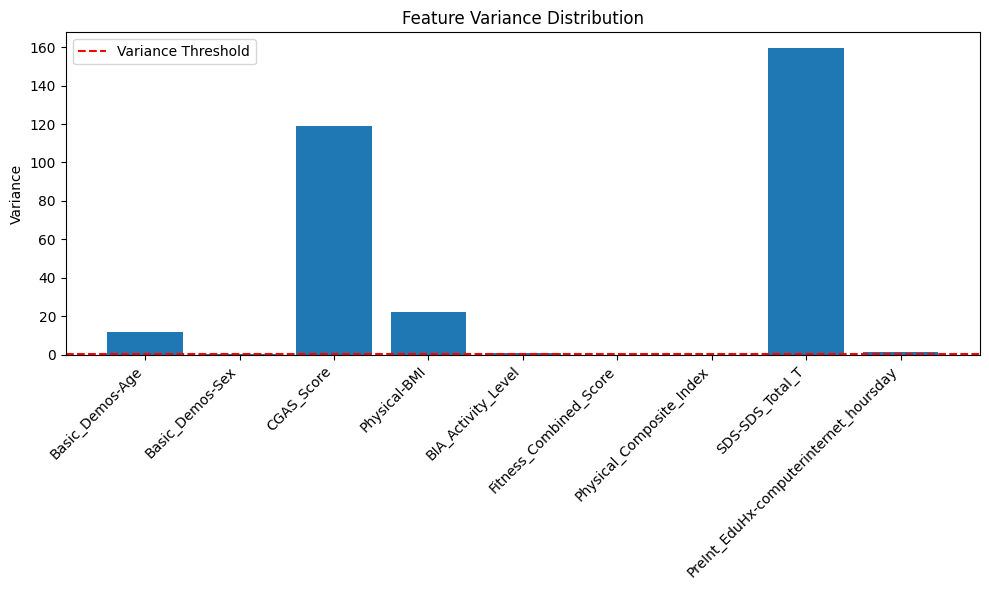

In [4]:

variance_threshold = 0.1

plt.figure(figsize=(10, 6))
plt.bar(feature_variances.index, feature_variances.values)
plt.axhline(y=variance_threshold, color='r', linestyle='--', label="Variance Threshold")
plt.xticks(rotation=45, ha="right")
plt.title("Feature Variance Distribution")
plt.ylabel("Variance")
plt.legend()
plt.tight_layout()
plt.show()


In [5]:
# Get the column names of features with variance above the threshold, I initially planned to but then dropped this idea
selected_features = feature_variances[feature_variances > 0.1].index

# Filter the data for high-variance features
X_high_variance = X[selected_features]

print(f"Selected High Variance Features:\n{selected_features}\n")
print(f"Reduced Feature Set Shape: {X_high_variance.shape}")


Selected High Variance Features:
Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS_Score', 'Physical-BMI',
       'BIA_Activity_Level', 'SDS-SDS_Total_T',
       'PreInt_EduHx-computerinternet_hoursday'],
      dtype='object')

Reduced Feature Set Shape: (2730, 7)


In [6]:
# PCA Analysis
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_high_variance)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

explained_variance = pca.explained_variance_ratio_
print(f"Explained Variance Ratio (PCA): {explained_variance}")
print(f"Cumulative Explained Variance: {np.cumsum(explained_variance)}")

Explained Variance Ratio (PCA): [0.26551433 0.16682021 0.15106567]
Cumulative Explained Variance: [0.26551433 0.43233453 0.5834002 ]


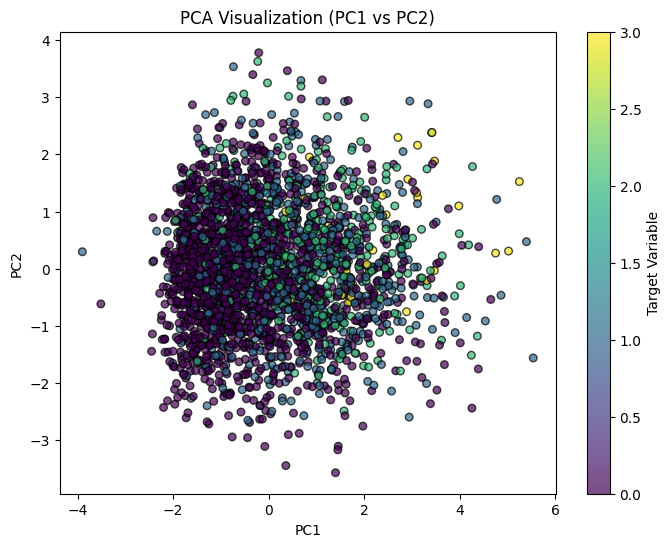

In [7]:
# Visualize PCA components
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("PCA Visualization (PC1 vs PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Target Variable")
plt.show()

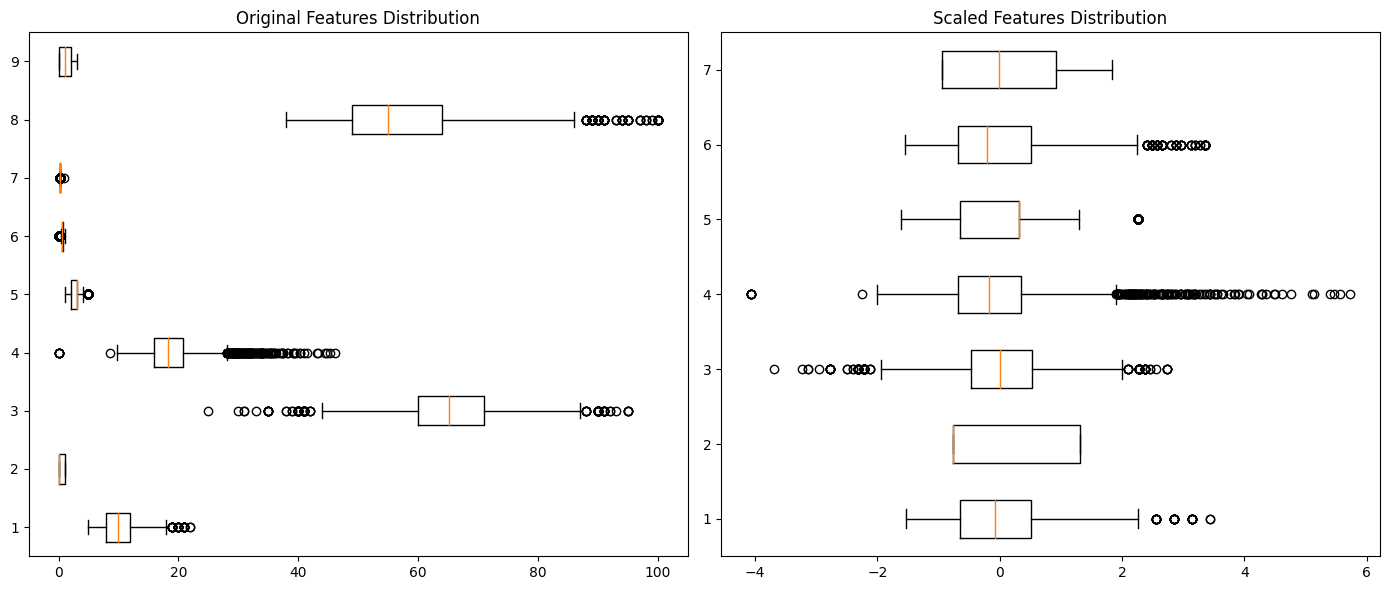

In [8]:
# Visualize original vs scaled features
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Before scaling
axes[0].boxplot(X.values, vert=False)
axes[0].set_title("Original Features Distribution")

# After scaling
axes[1].boxplot(X_scaled, vert=False)
axes[1].set_title("Scaled Features Distribution")

plt.tight_layout()
plt.show()


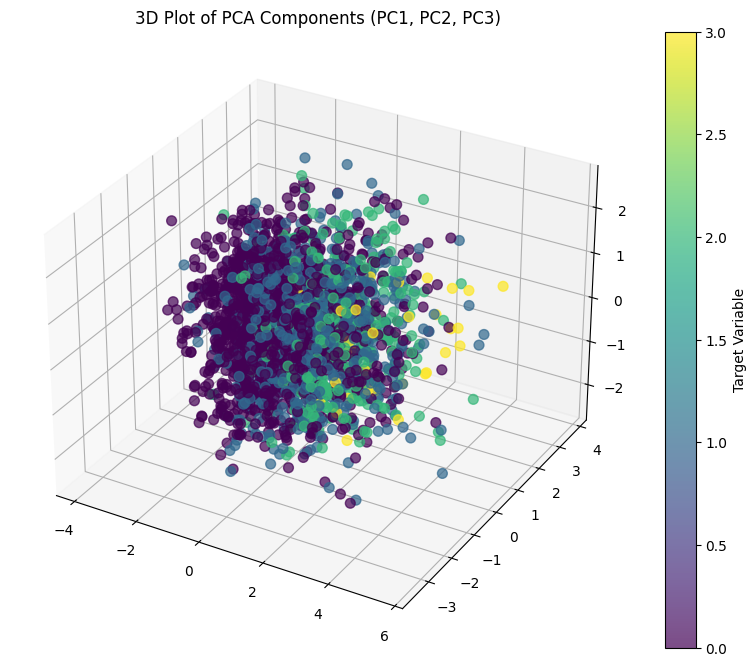

In [9]:
# 3D Plot of PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap="viridis", s=50, alpha=0.7)
plt.title("3D Plot of PCA Components (PC1, PC2, PC3)")
plt.colorbar(sc, label="Target Variable")
plt.show()

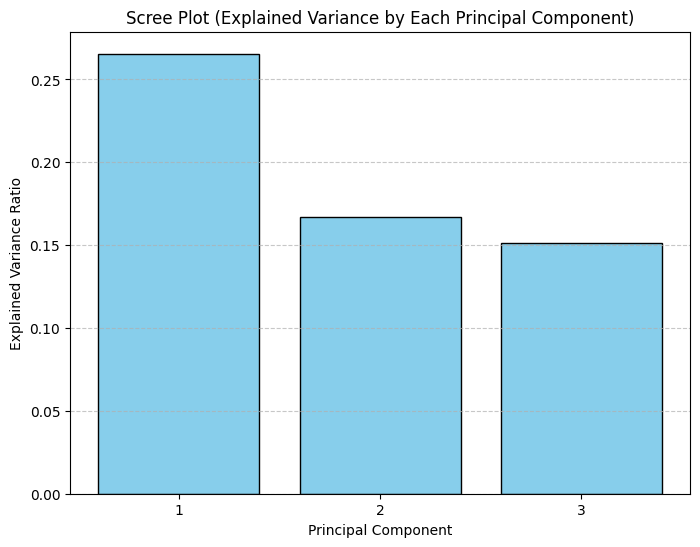

In [10]:
# Scree Plot for individual explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="skyblue", edgecolor="black")
plt.title("Scree Plot (Explained Variance by Each Principal Component)")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.xticks(range(1, len(explained_variance) + 1))
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


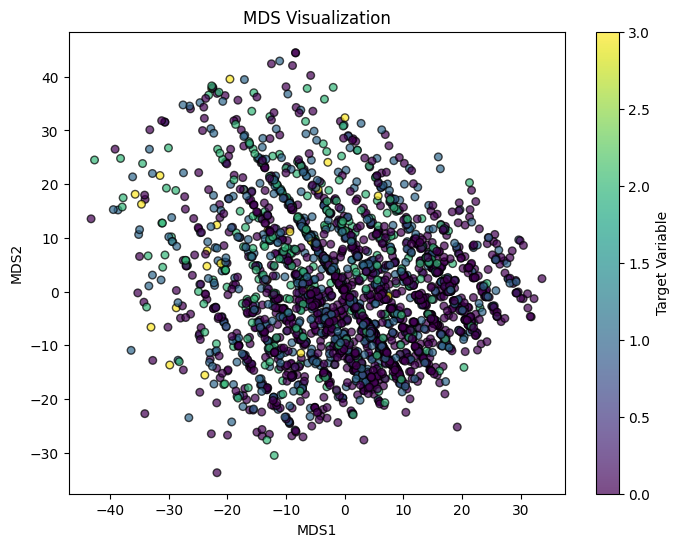

In [11]:
# trying Other Dimensionality Reduction Techniques
# MDS
from sklearn.manifold import MDS, TSNE, Isomap
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("MDS Visualization")
plt.xlabel("MDS1")
plt.ylabel("MDS2")
plt.colorbar(label="Target Variable")
plt.show()

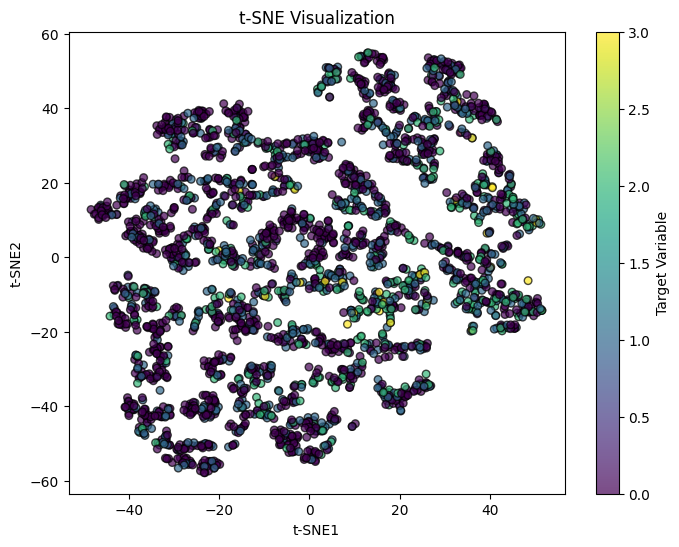

In [12]:
# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("t-SNE Visualization")
plt.xlabel("t-SNE1")
plt.ylabel("t-SNE2")
plt.colorbar(label="Target Variable")
plt.show()

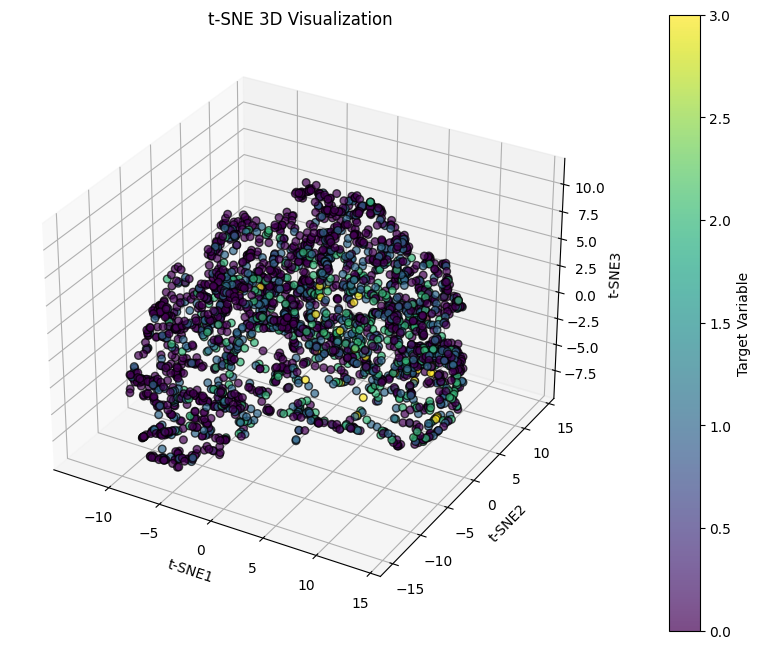

In [13]:
from mpl_toolkits.mplot3d import Axes3D

# t-SNE with 3 components
tsne = TSNE(n_components=3, random_state=42, perplexity=30)
X_tsne_3d = tsne.fit_transform(X_high_variance)

# 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_tsne_3d[:, 0], X_tsne_3d[:, 1], X_tsne_3d[:, 2], 
    c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7
)

# Titles and labels
ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel("t-SNE1")
ax.set_ylabel("t-SNE2")
ax.set_zlabel("t-SNE3")

# Colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Target Variable")
plt.show()


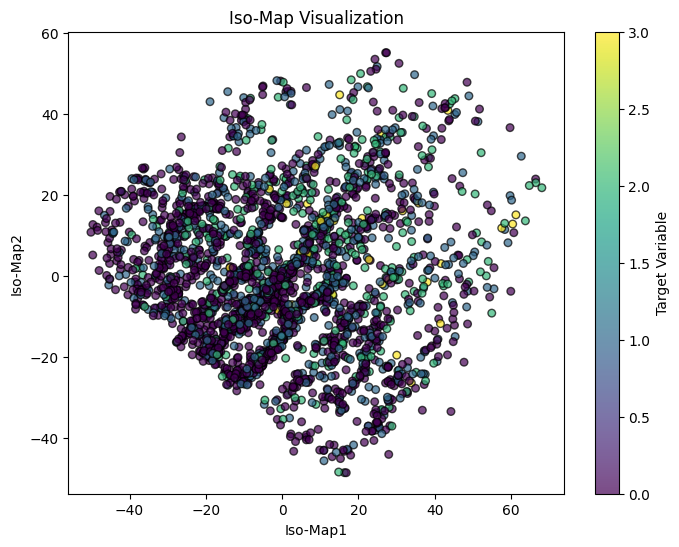

In [14]:
# Iso-map
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(X_high_variance)

plt.figure(figsize=(8, 6))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=y, cmap="viridis", s=30, edgecolor="k", alpha=0.7)
plt.title("Iso-Map Visualization")
plt.xlabel("Iso-Map1")
plt.ylabel("Iso-Map2")
plt.colorbar(label="Target Variable")
plt.show()

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB

# Naive Bayes Baseline to check how model is actually performing
X_train, X_test, y_train, y_test = train_test_split(X_pca_2d, y, test_size=0.3, random_state=42, stratify=y)
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("\nNaive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.93      0.75       477
         1.0       0.30      0.11      0.16       219
         2.0       0.36      0.08      0.13       113
         3.0       0.33      0.10      0.15        10

    accuracy                           0.58       819
   macro avg       0.40      0.31      0.30       819
weighted avg       0.50      0.58      0.50       819



I will try out two SVM models, one without resampling and one with

In [16]:
# Common SVM hyperparameters for both models
param_grid = {
    'C': [1],
    'gamma': [0.7],
    'kernel': ['rbf']
}

In [17]:
### Model 1: Without Resampling
print("Training SVM without resampling...")
grid_search_no_resampling = GridSearchCV(
    SVC(probability=True, class_weight='balanced', random_state=42),
    param_grid, cv=3, scoring='f1_weighted', n_jobs=-1
)
grid_search_no_resampling.fit(X_train, y_train)
best_params_no_resampling = grid_search_no_resampling.best_params_
print("Best Parameters (No Resampling):", best_params_no_resampling)

Training SVM without resampling...
Best Parameters (No Resampling): {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [18]:
# Evaluate on the test set
y_pred_no_resampling = grid_search_no_resampling.best_estimator_.predict(X_test)
print("\nClassification Report (No Resampling):")
print(classification_report(y_test, y_pred_no_resampling))


Classification Report (No Resampling):
              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71       477
         1.0       0.32      0.23      0.27       219
         2.0       0.24      0.41      0.30       113
         3.0       0.09      0.70      0.16        10

    accuracy                           0.50       819
   macro avg       0.36      0.50      0.36       819
weighted avg       0.57      0.50      0.53       819



In [19]:
### Model 2: With Resampling (SMOTE-Tomek)
print("\nTraining SVM with resampling...")
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

grid_search_with_resampling = GridSearchCV(
    SVC(probability=True, class_weight='balanced', random_state=42),
    param_grid, cv=3, scoring='f1_weighted', n_jobs=-1
)
grid_search_with_resampling.fit(X_resampled, y_resampled)
best_params_with_resampling = grid_search_with_resampling.best_params_
print("Best Parameters (With Resampling):", best_params_with_resampling)


Training SVM with resampling...
Best Parameters (With Resampling): {'C': 1, 'gamma': 0.7, 'kernel': 'rbf'}


In [20]:
# Evaluate on the test set
y_pred_with_resampling = grid_search_with_resampling.best_estimator_.predict(X_test)
print("\nClassification Report (With Resampling):")
print(classification_report(y_test, y_pred_with_resampling))


Classification Report (With Resampling):
              precision    recall  f1-score   support

         0.0       0.78      0.65      0.71       477
         1.0       0.32      0.29      0.31       219
         2.0       0.24      0.38      0.30       113
         3.0       0.09      0.40      0.15        10

    accuracy                           0.52       819
   macro avg       0.36      0.43      0.37       819
weighted avg       0.57      0.52      0.54       819



overall balance across all classes, the resampled model is better due to its higher macro F1-score and better recall for minority classes.

In [21]:
# Step 2: Hyperparameter Tuning for SVM
param_grid = {
    'C': [1],
    'gamma': [0.7],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}
grid_search = GridSearchCV(SVC(probability=True, class_weight='balanced', random_state=42),
                           param_grid, cv=3, scoring='f1_weighted', n_jobs=-1)

grid_search.fit(X_resampled, y_resampled)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

Best Parameters: {'C': 1, 'class_weight': 'balanced', 'gamma': 0.7, 'kernel': 'rbf'}


In [22]:
# Train SVM with best parameters
svm_model = SVC(**best_params, probability=True, random_state=42)
svm_model.fit(X_resampled, y_resampled)


SVC(C=1, class_weight='balanced', gamma=0.7, probability=True, random_state=42)

In [23]:
# Step 3: Analyze Support Vectors
support_vectors = svm_model.support_vectors_
num_support_vectors = len(support_vectors)
support_vector_indices = svm_model.support_
print(f"Number of Support Vectors: {num_support_vectors}")
print(f"Support Vector Indices: {support_vector_indices}")

Number of Support Vectors: 2853
Support Vector Indices: [   0    1    5 ... 3757 3759 3765]


In [24]:
y_pred = svm_model.predict(X_test)
y_prob = svm_model.predict_proba(X_test)

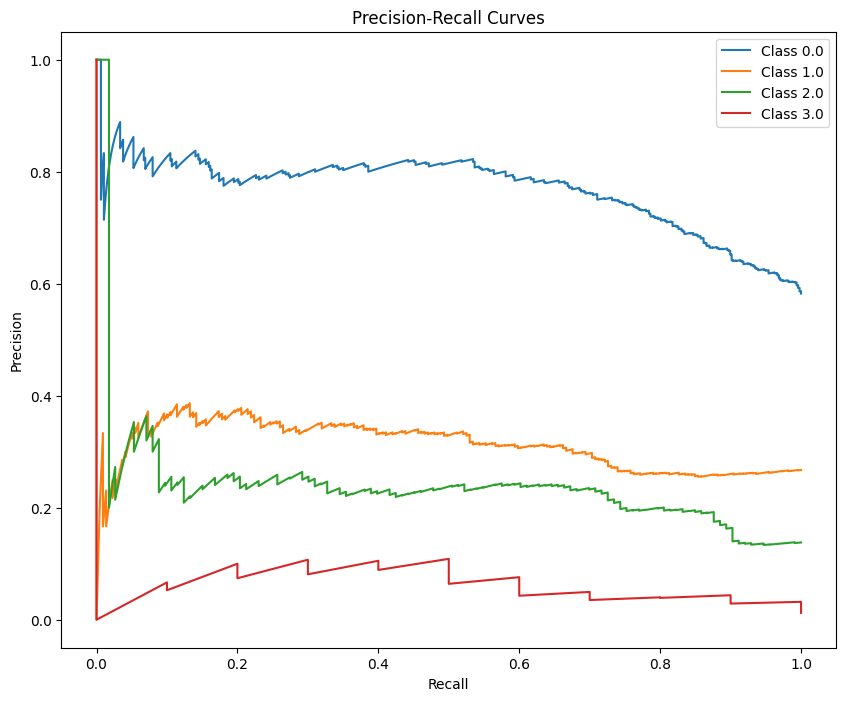

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [25]:
# Evaluate Precision-Recall and ROC Curves for each class
plt.figure(figsize=(10, 8))
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
for i, class_label in enumerate(np.unique(y)):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(recall, precision, label=f"Class {class_label}")
plt.title("Precision-Recall Curves")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

plt.figure(figsize=(10, 8))


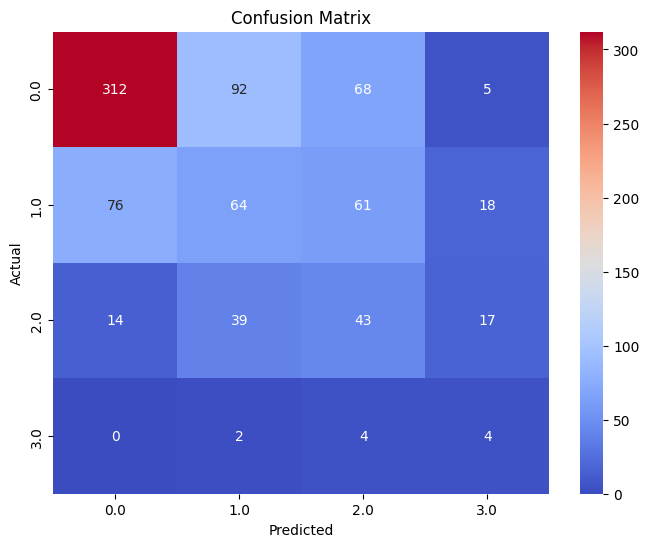

In [26]:
# Updated Confusion Matrix Visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap="coolwarm", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


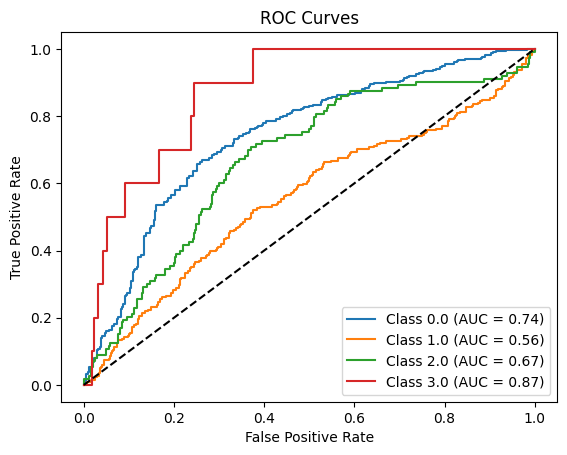

In [27]:
roc_auc_scores = roc_auc_score(y_test_binarized, y_prob, average=None)
for i, class_label in enumerate(np.unique(y)):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_label} (AUC = {roc_auc_scores[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [28]:
# Metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5164835164835165
Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.65      0.71       477
         1.0       0.32      0.29      0.31       219
         2.0       0.24      0.38      0.30       113
         3.0       0.09      0.40      0.15        10

    accuracy                           0.52       819
   macro avg       0.36      0.43      0.37       819
weighted avg       0.57      0.52      0.54       819

Confusion Matrix:
 [[312  92  68   5]
 [ 76  64  61  18]
 [ 14  39  43  17]
 [  0   2   4   4]]


In [29]:
import joblib

# Assuming 'wclf' is your trained model
model_path = '/kaggle/working/svm_tabulardata_model.pkl'

# Save the trained model to the specified path
joblib.dump(svm_model, model_path)


['/kaggle/working/svm_tabulardata_model.pkl']

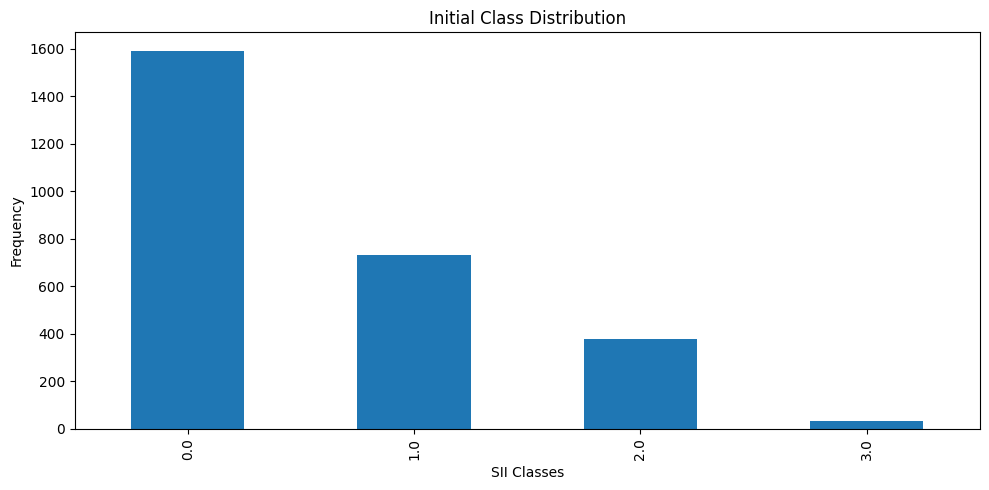


LINEAR Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       477
         1.0       0.00      0.00      0.00       219
         2.0       0.00      0.00      0.00       113
         3.0       0.00      0.00      0.00        10

    accuracy                           0.58       819
   macro avg       0.15      0.25      0.18       819
weighted avg       0.34      0.58      0.43       819



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


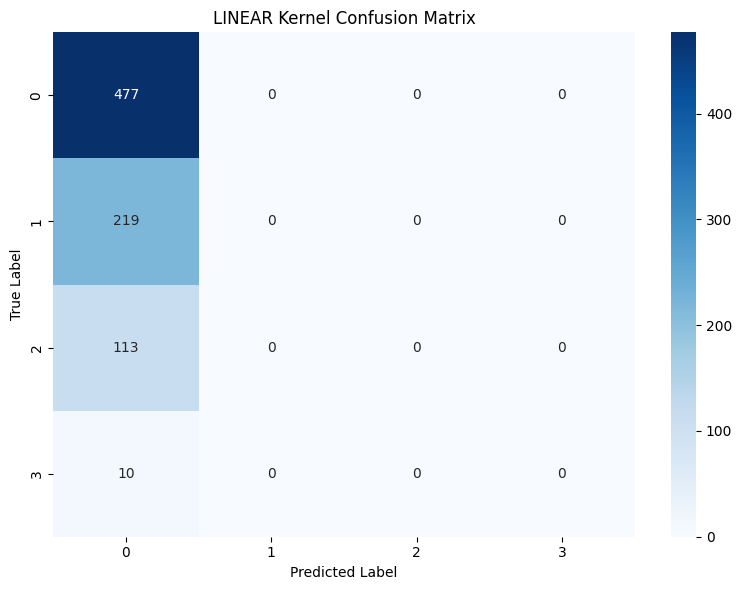

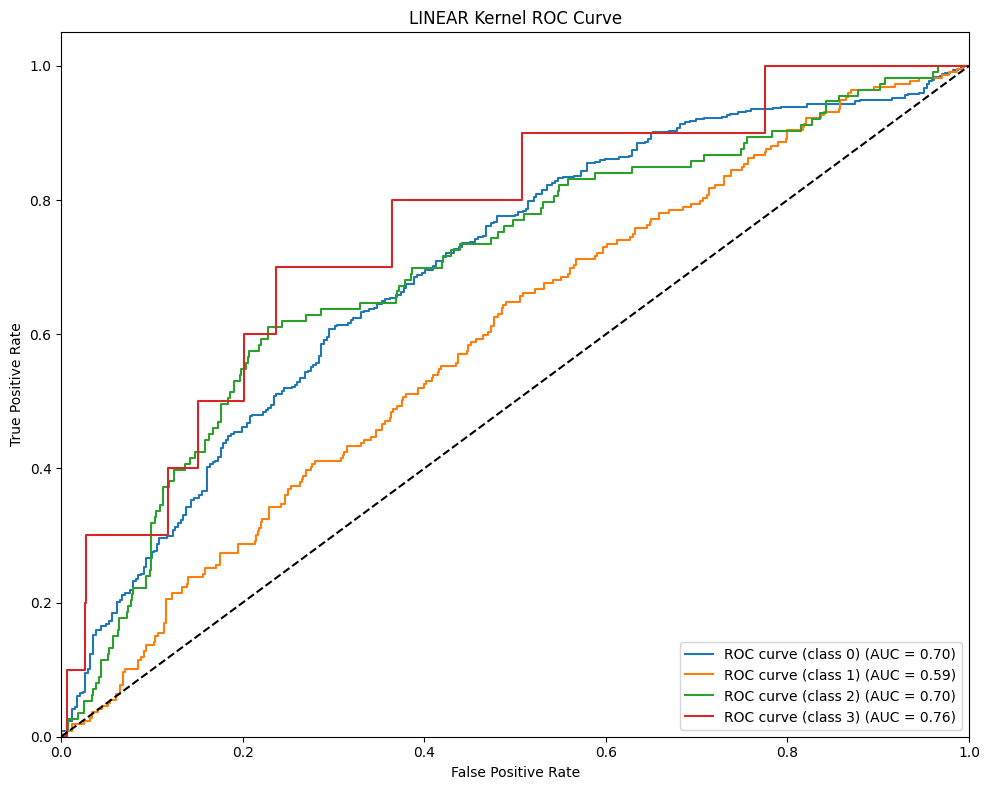

<Figure size 1000x800 with 0 Axes>

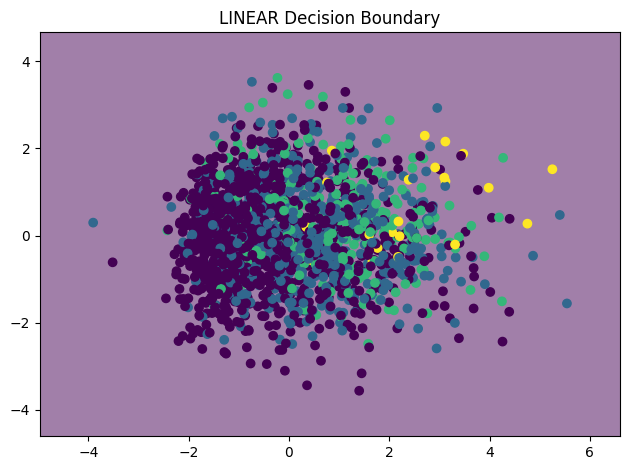

SVM Model Characteristics:
Number of Support Vectors: 1327
Support Vectors per Class:
  Class 0: 528 support vectors
  Class 1: 511 support vectors
  Class 2: 264 support vectors
  Class 3: 24 support vectors

POLY Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      1.00      0.74       477
         1.0       0.00      0.00      0.00       219
         2.0       0.00      0.00      0.00       113
         3.0       0.00      0.00      0.00        10

    accuracy                           0.58       819
   macro avg       0.15      0.25      0.18       819
weighted avg       0.34      0.58      0.43       819



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


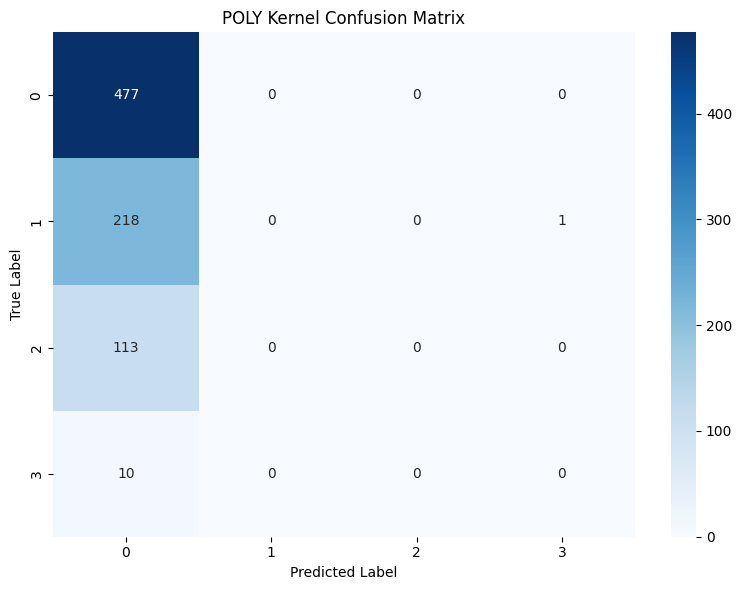

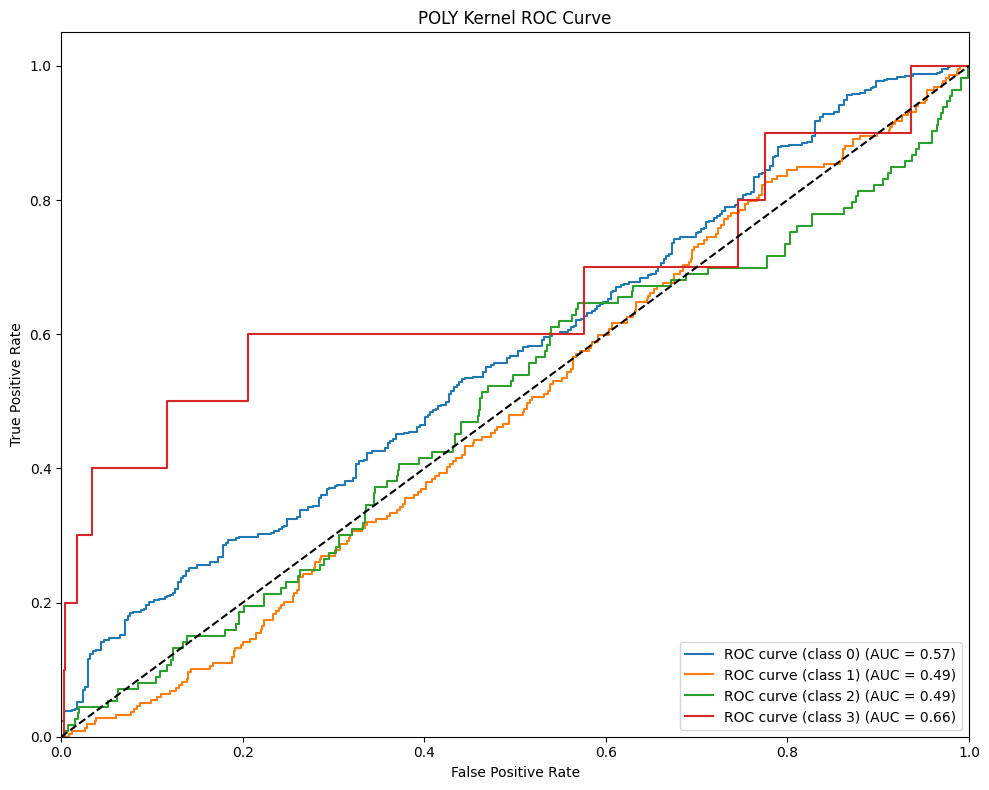

<Figure size 1000x800 with 0 Axes>

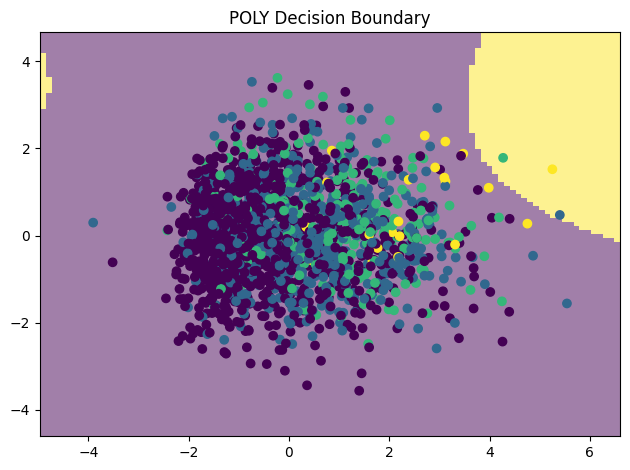

SVM Model Characteristics:
Number of Support Vectors: 1372
Support Vectors per Class:
  Class 0: 573 support vectors
  Class 1: 511 support vectors
  Class 2: 264 support vectors
  Class 3: 24 support vectors

RBF Kernel Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.96      0.75       477
         1.0       0.33      0.11      0.16       219
         2.0       0.00      0.00      0.00       113
         3.0       0.33      0.10      0.15        10

    accuracy                           0.59       819
   macro avg       0.32      0.29      0.27       819
weighted avg       0.45      0.59      0.48       819



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


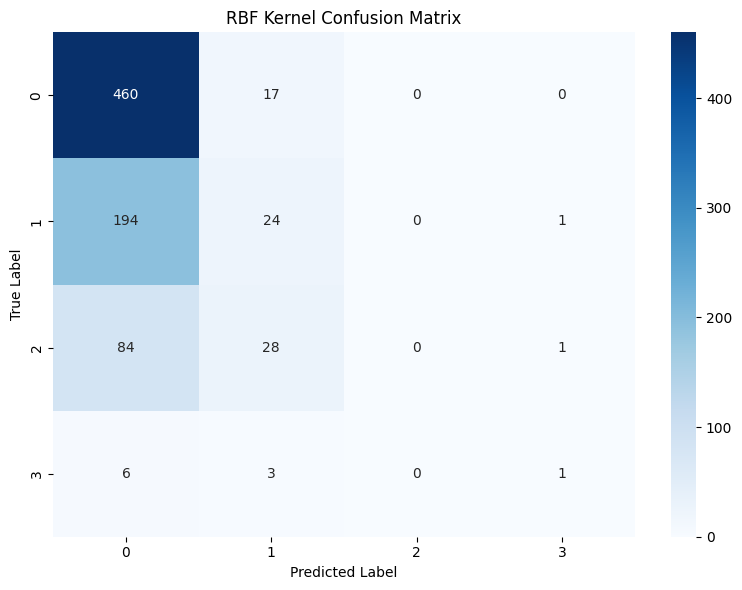

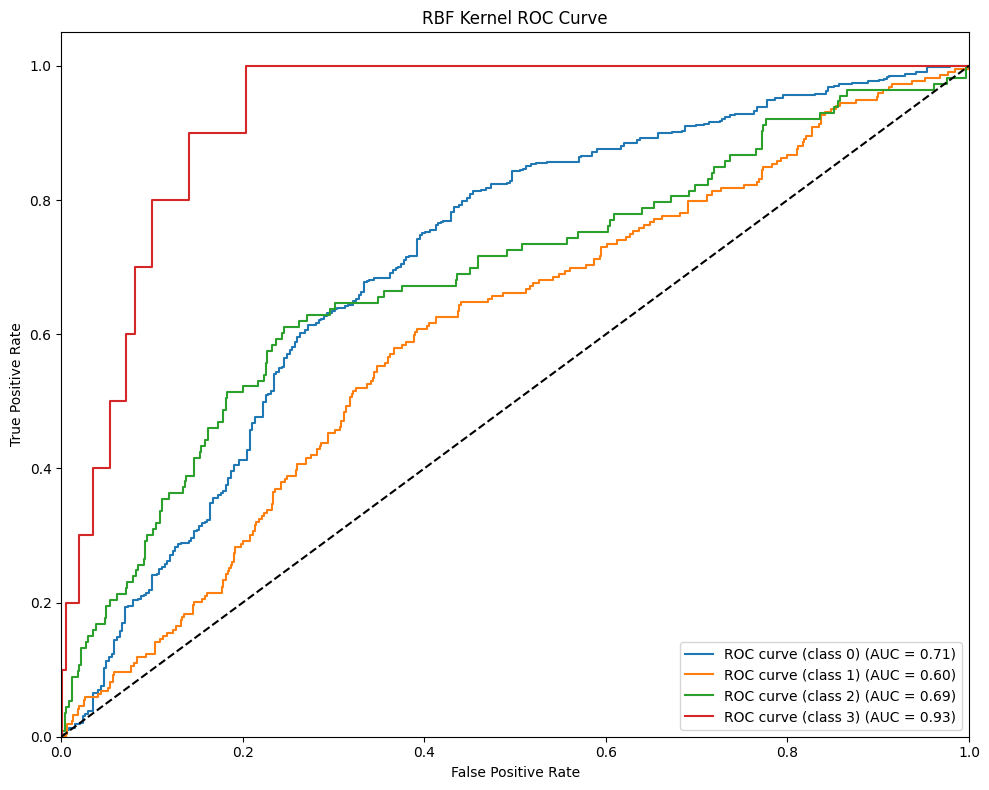

<Figure size 1000x800 with 0 Axes>

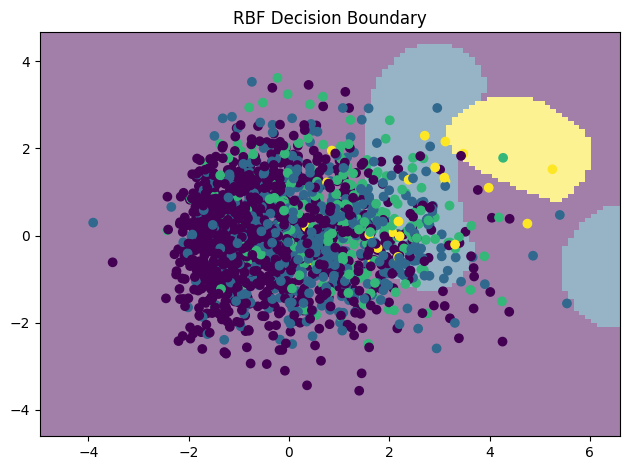

SVM Model Characteristics:
Number of Support Vectors: 1431
Support Vectors per Class:
  Class 0: 632 support vectors
  Class 1: 511 support vectors
  Class 2: 264 support vectors
  Class 3: 24 support vectors


In [30]:
# doing this whole process again but in a single pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                              roc_curve, roc_auc_score, f1_score)
from sklearn.decomposition import PCA
from sklearn.inspection import DecisionBoundaryDisplay



# Initial Class Distribution
plt.figure(figsize=(10, 5))
y.value_counts().plot(kind='bar')
plt.title('Initial Class Distribution')
plt.xlabel('SII Classes')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


# SVM Training with Different Kernels
kernels = ['linear', 'poly', 'rbf']
results = {}

for kernel in kernels:
    svm = SVC(kernel=kernel, probability=True)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    
    # Classification Report
    print(f"\n{kernel.upper()} Kernel Classification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{kernel.upper()} Kernel Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()
    
    # ROC Curve for Multiclass
    from sklearn.preprocessing import label_binarize
    y_test_bin = label_binarize(y_test, classes=np.unique(y))
    y_pred_proba = svm.predict_proba(X_test)
    
    plt.figure(figsize=(10, 8))
    for i in range(len(np.unique(y))):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
        roc_auc = roc_auc_score(y_test_bin[:, i], y_pred_proba[:, i])
        plt.plot(fpr, tpr, label=f'ROC curve (class {i}) (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{kernel.upper()} Kernel ROC Curve')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()
    
    # Decision Boundary Visualization
    plt.figure(figsize=(10, 8))
    DecisionBoundaryDisplay.from_estimator(
        svm, X_train, response_method="predict",
        plot_method="pcolormesh", shading="auto", alpha=0.5
    )
    plt.title(f'{kernel.upper()} Decision Boundary')
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
    plt.tight_layout()
    plt.show()
    print("SVM Model Characteristics:")
    print(f"Number of Support Vectors: {svm.support_vectors_.shape[0]}")
    print(f"Support Vectors per Class:")
    for i, count in enumerate(svm.n_support_):
        print(f"  Class {i}: {count} support vectors")


In [31]:
import joblib

# Assuming 'wclf' is your trained model
path_to_scaler = '/kaggle/working/svm_tabulardata_scaler.pkl'
path_to_pca = '/kaggle/working/svm_tabulardata_pca.pkl'
path_to_svm_model = '/kaggle/working/svm_tabulardata_model.pkl'
path_to_selected_features = '/kaggle/working/svm_tabulardata_selected_features.pkl'


# Save the trained model to the specified path
joblib.dump(svm_model, path_to_svm_model)
joblib.dump(scaler, path_to_scaler)  # Save scaler
joblib.dump(pca_2d, path_to_pca)  # Save PCA
joblib.dump(selected_features, path_to_selected_features) # save selected features


['/kaggle/working/svm_tabulardata_selected_features.pkl']

Now we will use this saved model to do the testing on our test dataset

In [32]:
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix, classification_report

#Load Saved Components
scaler = joblib.load(path_to_scaler)
pca_2d = joblib.load(path_to_pca)
svm_model = joblib.load(path_to_svm_model)
selected_features = joblib.load(path_to_selected_features)

In [33]:
# Load the new test dataset
test_data_path = '/kaggle/input/testdataset/cleaned_test.csv'
test_dataset = pd.read_csv(test_data_path)

# Check the number of missing values per column
missing_values_count = test_dataset.isnull().sum()

# Print out the count of missing values for each column
print("Missing values count per column:")
print(missing_values_count)

total_missing_values = missing_values_count.sum()
print(f"Total number of missing values in the dataset: {total_missing_values}")


Missing values count per column:
id                                        0
Basic_Demos-Age                           0
Basic_Demos-Sex                           0
CGAS_Score                                0
Physical-BMI                              0
BIA_Activity_Level                        0
Fitness_Combined_Score                    0
Physical_Composite_Index                  0
SDS-SDS_Total_T                           0
PreInt_EduHx-computerinternet_hoursday    0
dtype: int64
Total number of missing values in the dataset: 0


In [34]:
# Apply feature selection (using selected_features from the training phase)
X_test_high_variance = test_dataset[selected_features]

# Scale and Apply PCA (using the saved scaler and PCA)
X_test_scaled = scaler.transform(X_test_high_variance)
X_test_pca = pca_2d.transform(X_test_scaled)

# Step 4: Make Predictions
y_pred = svm_model.predict(X_test_pca)
y_pred_proba = svm_model.predict_proba(X_test_pca)

predictions_df = pd.DataFrame({
    'id': test_dataset['id'],  # Replace with actual id column
    'sii': y_pred
})
predictions_df.to_csv('/kaggle/working/predictions.csv', index=False)

predictions_proba_df = pd.DataFrame(y_pred_proba, columns=[f'Class_{i}_Prob' for i in range(y_pred_proba.shape[1])])
predictions_proba_df.to_csv('/kaggle/working/predictions_with_probabilities.csv', index=False)

# Output the predictions if needed
print(y_pred)

[1. 0. 1. 0. 1. 2. 2. 1. 2. 1. 1. 0. 1. 2. 2. 2. 0. 1. 2. 2.]
